In [218]:
import math 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [219]:
def f(x):
    return 3*x**2 - 4*x + 5

In [220]:
f(3.0)

20.0

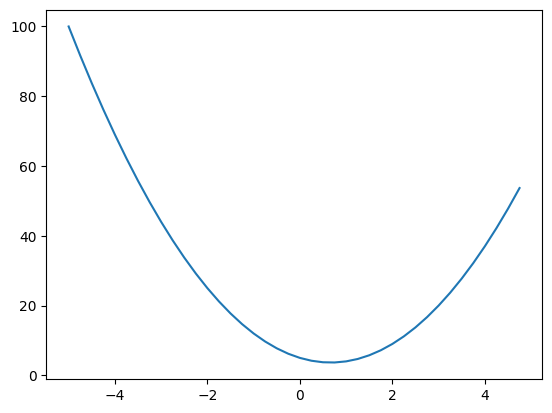

In [221]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.0000000001
x = 3.0
(f(x+h)-f(x))/h # numerical approximation of slope

14.000001158365194

In [6]:
# More complex example
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [61]:
h = 0.0001

#inputs 
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h  # change a, b, c and observe how each variable affects the slope
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

# Understand the results 
# a += h -> slope = -3.0 = b
# b += h -> slope = 2.0 = a
# c += h -> slope = 1.0 = c

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


### Create a new object named Value

In [439]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        # _children keeps a set of values used to create the new Value object
        self._prev = set(_children)
        # _opt keeps information on which operation was used 
        self._op = _op
        self.label = label

    # Define how we wnat to print out our Value objects 
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        # allow addition with integers (not only Value objects)
        other = other if isinstance(other, Value) else Value(other)
        
        # return a new value object with the added value. 
        out = Value(self.data + other.data, (self, other), '+')
        # Since data is a Python number, not a Value object, we can use a typical floating point addition.  
        
        def _backward(): # same as out.grad
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other
        

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():  # use chain rule
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad 
        out._backward = _backward

        return out
    
    def __rmul__(self, other): # other * self
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward
        
        return out

        
    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    
    # Used for tanh - activation function 
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward(): # derivative of tanh is 1-tanh^2
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data 
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward
    
        return out
        
    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

In [440]:
# Value objects 
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

# Value Operations 
a + b # internally -> a.__add__(b)

a * b # internally -> a.__mul__(b)

d = (a.__mul__(b)).__add__(c)
d # d = a*b + c

d._prev # prints out a*b = -6.0 and c = 10.0

d._op # prints out '+' because addition was the last operation used to create d 

# define e and d 
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data=-8.0)

In [441]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f  | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

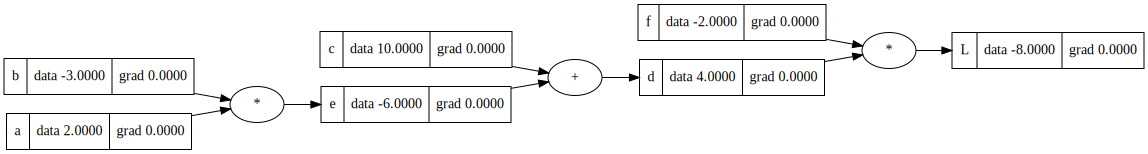

In [442]:
draw_dot(L)

#### Now let's find the gradients using Calculus

In [443]:
# Gradient check - change location of h and find gradient for each variable 
def lol():

    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data

    print((L2-L1)/h)

lol()

6.000000000021544


#### Use the definition of Calculus

L = d * f

dL/dd = f 

Calculus:
(f(x+h)-f(x))/h

-> ((d+h)*f-d*f)/h

-> (d*f + h*f - d*f) / h

-> (h*f) / h

-> f 

Symmetrically:
dL/df = d 

In [444]:
f.grad = d.data # 4.0
d.grad = f.data # -2.0

In [445]:
L.grad = 1.0

#### Using Chain Rule:

dL/dc = (dL/dd)*(dd/dc)

We know L = d * f ; and d = e + c 

-> (f) * (1)

-> f

Symmetrically: dL/de = f

In [446]:
c.grad = f.data
e.grad = f.data

#### Use the chain rule again:

dL/da = (dL/dd)*(dd/de)*(de/da)

-> (f)*(1)*(b)

-> f*b

Symmetrically:d dL/db = f*a

In [447]:
a.grad = f.data * b.data
b.grad = f.data * a.data

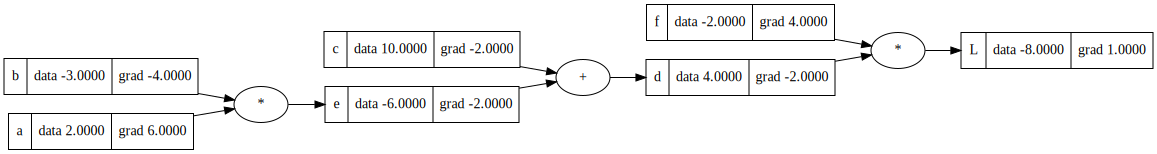

In [448]:
draw_dot(L)

In [449]:
a.data += 0.01 * a.grad 
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# do the forward pass again after nudging the values 
e = a * b
d = e + c 
L = d * f

print(L.data)

-7.286496


### Back propagate through a Neuron 

In [9]:
from PIL import Image

# Open the uploaded image
img_path = 'cs231n.png' # from url: https://cs231n.github.io/neural-networks-1/
img = Image.open(img_path)

# Get original dimensions
original_width, original_height = img.size

# Calculate new dimensions (scale to 50%)
new_width = int(original_width * 0.5)
new_height = int(original_height * 0.5)

# Resize the image
scaled_img = img.resize((new_width, new_height))

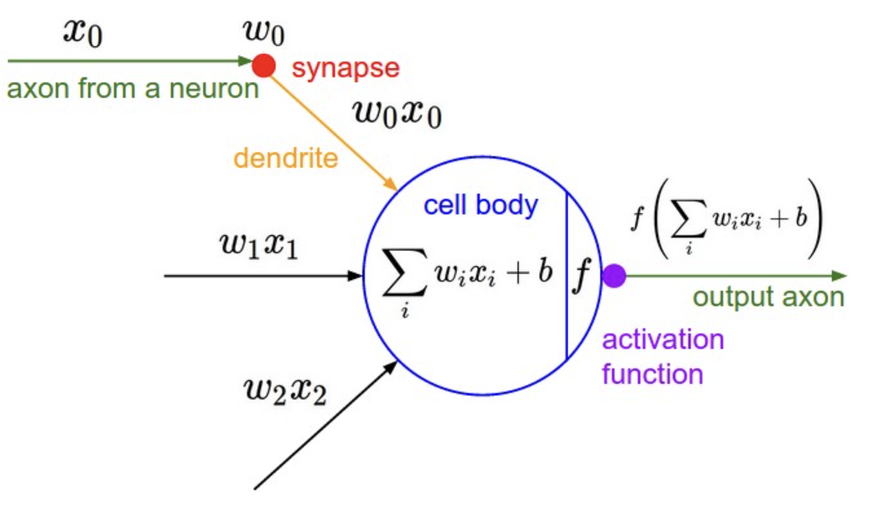

In [10]:
img_path = 'cs231n_scaled.png' # from url: https://cs231n.github.io/neural-networks-1/
img = Image.open(img_path)
img

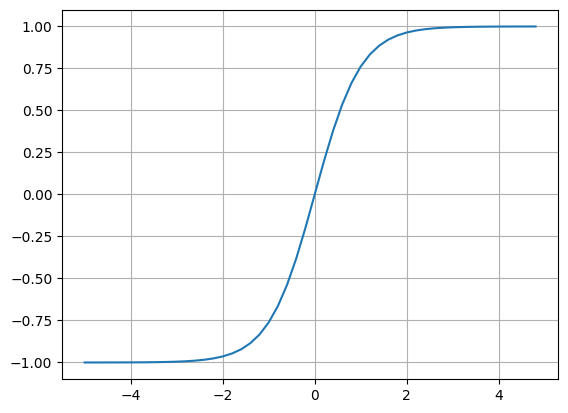

In [451]:
# Activation functions 
# Ex: tanh
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

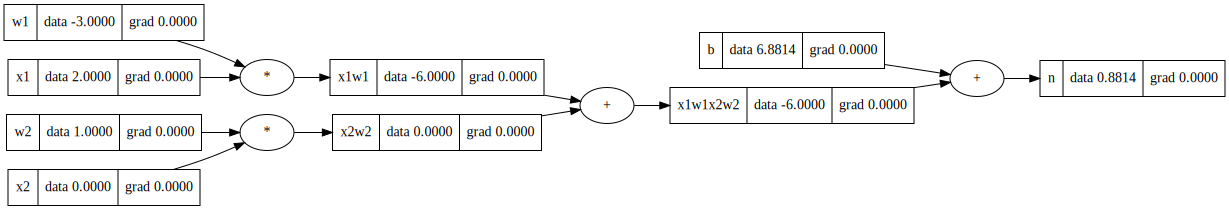

In [452]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron 
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2 + b; n.label='n' # cell body without the activation function
draw_dot(n)

In [453]:
# Let's use the tanh activation function 
# Go back to Value class instantiation and add division, exponents, etc.
# But we do not have to define the most atomic pieces for tanh
# We will directly define the tanh function 
o = n.tanh(); o.label='o'

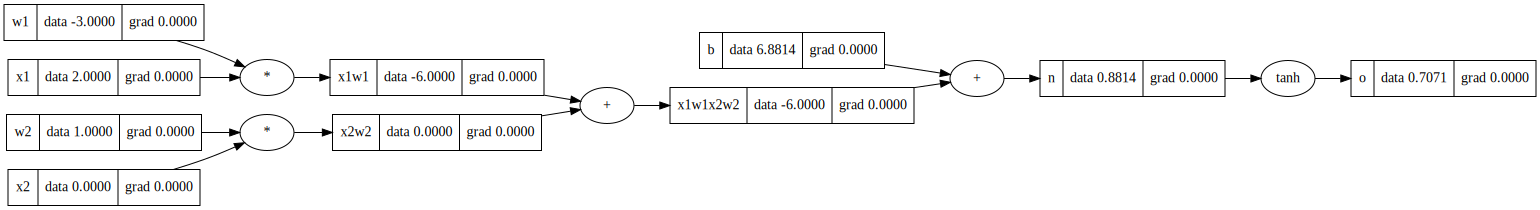

In [454]:
# Re-run this code after finding the gradient for each variable
draw_dot(o)

In [455]:
o.grad = 1.0

In [456]:
# o = tanh(n) 
# derivative of tanh is 1-tanh^2
# do/dn = 1 - tanh(n)**2 = 1 - o**2
n.grad = 1 - o.data**2
n.grad

0.4999999999999999

In [457]:
# Since n = x1w1x2w2 + b, it uses addition 
# and therefore follow the gradient of x1w1x2w2 and b follows the gradient of n 
x1w1x2w2.grad = n.grad
b.grad = n.grad

In [458]:
# Same way
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

In [459]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [460]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

### Let's do backpropagation by implementing the backward function
Don't do the gradient calculation manually anymore. 

Go back to class Value and add self._backward.


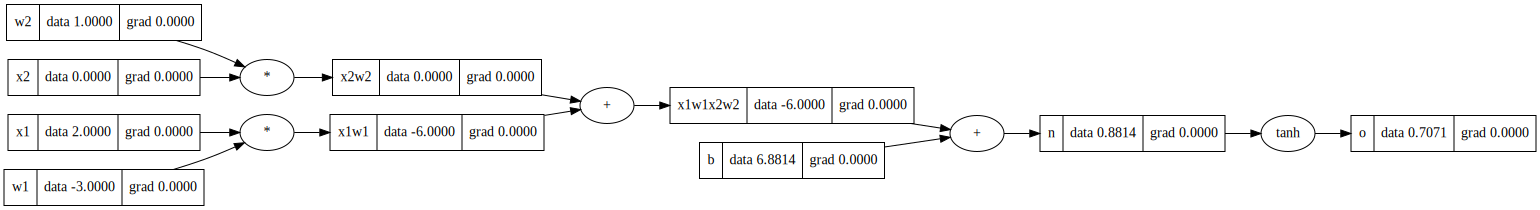

In [461]:
# Redifine out inputs (same as above) 
# This time, we won't calculate the gradients manually

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron 
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2 + b; n.label='n' # cell body without the activation function
o = n.tanh(); o.label='o'
draw_dot(o)

In [462]:
# Let's call ._backward() in order
o.grad = 1.0 # need to initialize this to 1 

In [463]:
o._backward()

In [464]:
n._backward()

In [465]:
b._backward()
x1w1x2w2._backward()

In [466]:
x1w1._backward()
x2w2._backward()

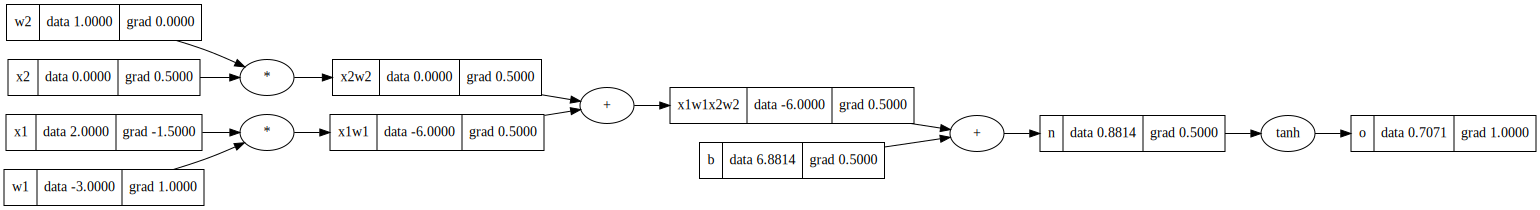

In [467]:
draw_dot(o)

### Topological Sort
Add the following function inside the Value class. Define a new function called backwards()

In [468]:
# The following code is inside the Value class inside the backwards() function
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o) # Start the topological sort at o (output)

for node in reversed(topo):
    node._backward()

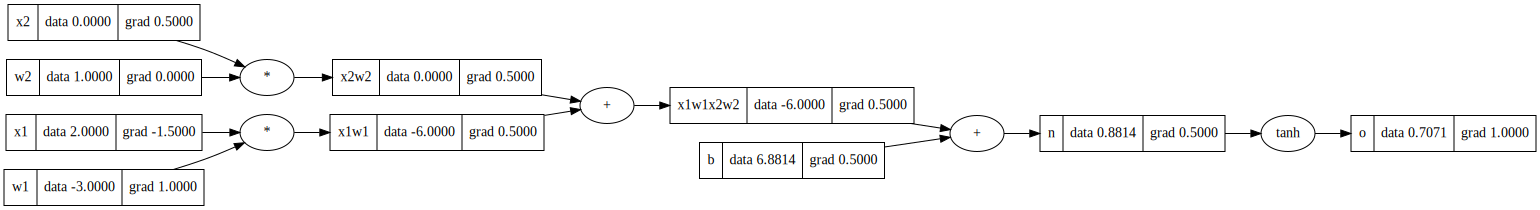

In [469]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron 
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'
o.backward() # This will calculate all the gradients!
draw_dot(o)

### Spot and Fix backprop bug when one node is used multiple times

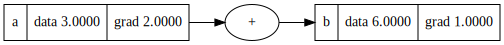

In [470]:
a = Value(3.0, label='a')
b = a + a ; b.label='b'
b.backward()
draw_dot(b)
# a.grad should be 2, but it prints out 1 
# Go back to the Value class and change self.grad = " " to self.grad += " "
# In multivariate cases, the gradients add up. And it is safe to use += since we are initializing them to 0. 

### Create more operations with Value 
Currently if we try a + 1 we get an error because 1 is not an Value type variable and doest have .data. Let's fix Value class so that it can perform addition and multiplicaiton with integers. 

In [471]:
a = Value(2.0)
a + 1

Value(data=3.0)

In [472]:
a * 2

Value(data=4.0)

#### rmul 
a * 2 works! However, 2 * a would cause an error. It is trying to do 2.__ mul __(a) which isn't defined. Go back to Value class and define __ rmul __.

2 * a will redirect to rmul and rmul will call a * 2.

Do the same for radd. 

In [473]:
2 * a

Value(data=4.0)

In [474]:
5 + a

Value(data=7.0)

#### exp
Let's also define the exponential function. 

In [475]:
a = Value(2.0)
a.exp()

Value(data=7.38905609893065)

#### div -> pow & truediv
Let's implement division, but something more powerful. 

a / b = a * (1/b) = a * (b**-1) 

We will implement the power function and use that to define division. 

In [476]:
a = Value(2.0)
b = Value(3.0)
a / b

Value(data=0.6666666666666666)

In [477]:
# Create __sub__ as well. 
a - b

Value(data=-1.0)

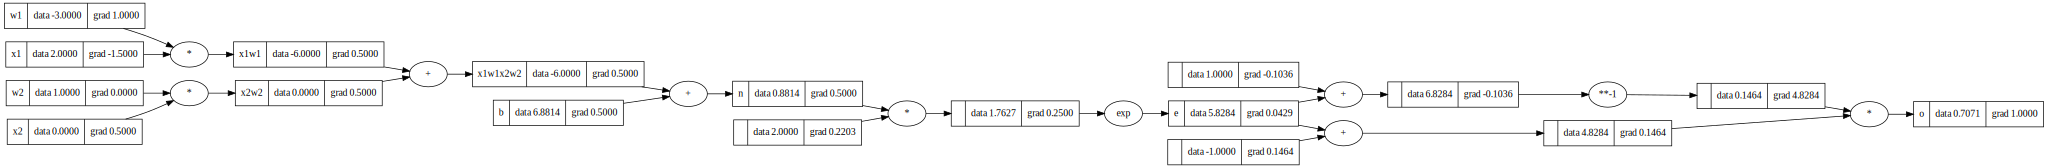

In [479]:
# Redifine out inputs (same as above) 
# This time, we want to break up tanh 

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron 
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2 + b; n.label='n'
# -----
e = (2*n).exp() ; e.label='e'
o = (e - 1) / (e + 1)
# -----
o.label='o'
o.backward()
draw_dot(o)